In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/datanueva/data-original3/test/4-celulas/103_crop.png
/kaggle/input/datanueva/data-original3/test/4-celulas/2863_crop.png
/kaggle/input/datanueva/data-original3/test/4-celulas/3589_crop.png
/kaggle/input/datanueva/data-original3/test/4-celulas/3217_crop.png
/kaggle/input/datanueva/data-original3/test/4-celulas/3838_crop.png
/kaggle/input/datanueva/data-original3/test/4-celulas/5778_crop.png
/kaggle/input/datanueva/data-original3/test/4-celulas/1533_crop.png
/kaggle/input/datanueva/data-original3/test/4-celulas/12648_crop.png
/kaggle/input/datanueva/data-original3/test/5-celulas/4110_crop.png
/kaggle/input/datanueva/data-original3/test/2-celulas/5611_crop.png
/kaggle/input/datanueva/data-original3/test/2-celulas/5210_crop.png
/kaggle/input/datanueva/data-original3/test/2-celulas/4938_crop.png
/kaggle/input/datanueva/data-original3/test/2-celulas/5346_crop.png
/kaggle/input/datanueva/data-original3/test/2-celulas/4517_crop.png
/kaggle/input/datanueva/data-original3/test/2-ce

In [2]:
import torch
import torchvision
import glob
import numpy
import cv2
import math
import matplotlib.pyplot as plt
import keras
from skimage import io
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
from torchvision.transforms import Compose, ToTensor, Resize
import torchvision.models as models
from keras.models import Model
from keras.layers import Input
from keras.layers import Activation
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import add
from keras.layers.merge import concatenate

In [3]:
data_dir = "/kaggle/input/datanueva/data-original3/train"
test_data_dir = "/kaggle/input/datanueva/data-original3/test"

dataset = ImageFolder(data_dir,transform = transforms.Compose([transforms.Resize((200,200)),transforms.ToTensor()]))
test_dataset = ImageFolder(test_data_dir,transforms.Compose([transforms.Resize((200,200)),transforms.ToTensor()]))

In [4]:
img, label = dataset[0]
print(img.shape,label)
print("Clases del dataset : \n",dataset.classes)

torch.Size([3, 200, 200]) 0
Clases del dataset : 
 ['2-celulas', '3-celulas', '4-celulas', '5-celulas']


Label : 2-celulas


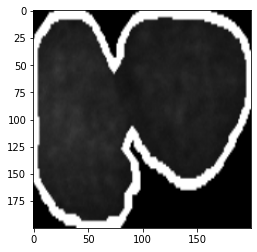

In [5]:
def display_img(img,label):
    print(f"Label : {dataset.classes[label]}")
    plt.imshow(img.permute(1,2,0))

display_img(*dataset[1])

In [6]:
batch_size = 32
val_size = 32
train_size = len(dataset) - val_size 
train_data,val_data = random_split(dataset,[train_size,val_size])
print(f"Tamano del train : {len(train_data)}")
print(f"Tamano de la validacion : {len(val_data)}")

train_data=dataset
val_data=test_dataset

train_dl = DataLoader(train_data, batch_size, shuffle = True, num_workers = 3, pin_memory = True)
val_dl = DataLoader(val_data, batch_size*2, num_workers = 3, pin_memory = True)

Tamano del train : 385
Tamano de la validacion : 32


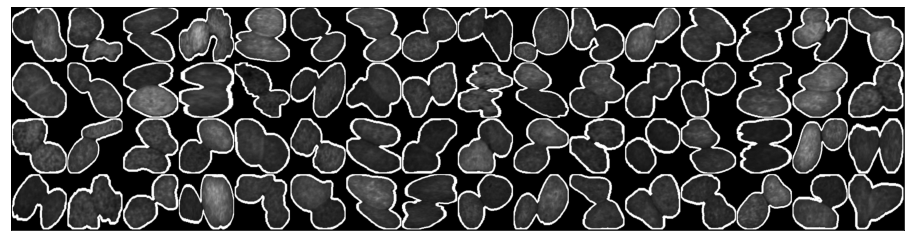

In [7]:
def show_batch(dl):
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(val_dl)

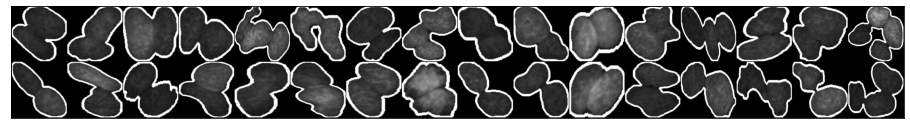

In [8]:
def show_batch(dl):
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(train_dl)

In [9]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [10]:
"""
num_classes = 4
class CNNIn(CNN):
    def __init__(self,num_clases=4):
        super(CNNIn,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=3, stride=1, padding=1)
        self.relu4 = nn.ReLU()
        self.fc = nn.Linear(in_features=125 * 100 * 24, out_features=num_classes)

    def forward(self, input):
        output = self.conv1(input)
        output = self.relu1(output)
        output = self.conv2(output)
        output = self.relu2(output)
        output = self.pool(output)
        output = self.conv3(output)
        output = self.relu3(output)
        output = self.conv4(output)
        output = self.relu4(output)
        output = output.view(-1, 125 * 100 * 24)
        output = self.fc(output)
        return output
"""

'\nnum_classes = 4\nclass CNNIn(CNN):\n    def __init__(self,num_clases=4):\n        super(CNNIn,self).__init__()\n        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)\n        self.relu1 = nn.ReLU()\n        self.conv2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, stride=1, padding=1)\n        self.relu2 = nn.ReLU()\n        self.pool = nn.MaxPool2d(kernel_size=2)\n        self.conv3 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1)\n        self.relu3 = nn.ReLU()\n        self.conv4 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=3, stride=1, padding=1)\n        self.relu4 = nn.ReLU()\n        self.fc = nn.Linear(in_features=125 * 100 * 24, out_features=num_classes)\n\n    def forward(self, input):\n        output = self.conv1(input)\n        output = self.relu1(output)\n        output = self.conv2(output)\n        output = self.relu2(output)\n        output = self.pool(output)\n      

In [11]:
num_classes = 4
#kernel_init = keras.initializers.glorot_uniform()
#bias_init = keras.initializers.Constant(value=0.2)
def inception_module(layer_in, f1, f2, f3, f2_reduce, f3_reduce, filtrado):
    conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
    conv3 = Conv2D(f2_reduce, (3,3), padding='same', activation='relu')(layer_in)
    conv3 = Conv2D(f2, (3,3), padding='same', activation='relu')(conv3)
    conv5 = Conv2D(f3_reduce, (5,5), padding='same', activation='relu')(layer_in)
    conv5 = Conv2D(f3, (5,5), padding='same', activation='relu')(conv5)
    pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
    pool = Conv2D(filtrado, (1,1), padding='same', activation='relu')(pool)
    layer_out = concatenate([conv1, conv3, conv5, pool], axis=-1)
    return layer_out

visible = Input(shape=(256, 256, 3))
layer = inception_module(visible, 64, 96, 128, 16, 32, 32)
layer = inception_module(layer, 128, 128, 192, 32, 96, 64)
modelo = Model(inputs=visible, outputs=layer)
modelo.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 256, 256, 32) 2432        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 256, 256, 3)  0           input_1[0][0]                    
______________________________________________________________________________________________


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

In [12]:
"""
num_classes = 4
class CNNIn(CNN):
    def __init__(self, train_CNN=True, num_classes=1):
        super(CNNIn,self).__init__()
        def inception_module(layer_in, f1, f2, f3, f2_reduce, f3_reduce, filtrado):
            self.conv1 = nn.Conv2D(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding='same')
            self.relu1 = nn.ReLU()
            self.conv3 = nn.Conv2D(f2_reduce, (3,3), padding='same', activation='relu')
            self.relu2 = nn.ReLU()
            self.conv3 = nn.Conv2D(f2, (3,3), padding='same', activation='relu')
            self.relu3 = nn.ReLU()
            self.conv5 = nn.Conv2D(f3_reduce, (5,5), padding='same', activation='relu')
            self.relu4 = nn.ReLU()
            self.conv5 = nn.Conv2D(f3, (5,5), padding='same', activation='relu')
            self.relu5 = nn.ReLU()
            self.pool = nn.MaxPooling2D((3,3), strides=(1,1), padding='same')
            self.pool = nn.Conv2D(filtrado, (1,1), padding='same', activation='relu')
            self.relu6 = nn.ReLU()
            self.layer_out = concatenate([conv1, conv3, conv5, pool], axis=-1)
            return layer_out

        def forward(self, input):
        output = self.conv1(input)
        output = self.relu1(output)
        output = self.conv2(output)
        output = self.relu2(output)
        output = self.conv3(output)
        output = self.relu3(output)
        output = self.conv4(output)
        output = self.relu4(output)
        output = output.view(-1, 125 * 100 * 24)
        output = self.fc(output)
        return output
"""

"\nnum_classes = 4\nclass CNNIn(CNN):\n    def __init__(self, train_CNN=True, num_classes=1):\n        super(CNNIn,self).__init__()\n        def inception_module(layer_in, f1, f2, f3, f2_reduce, f3_reduce, filtrado):\n            self.conv1 = nn.Conv2D(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding='same')\n            self.relu1 = nn.ReLU()\n            self.conv3 = nn.Conv2D(f2_reduce, (3,3), padding='same', activation='relu')\n            self.relu2 = nn.ReLU()\n            self.conv3 = nn.Conv2D(f2, (3,3), padding='same', activation='relu')\n            self.relu3 = nn.ReLU()\n            self.conv5 = nn.Conv2D(f3_reduce, (5,5), padding='same', activation='relu')\n            self.relu4 = nn.ReLU()\n            self.conv5 = nn.Conv2D(f3, (5,5), padding='same', activation='relu')\n            self.relu5 = nn.ReLU()\n            self.pool = nn.MaxPooling2D((3,3), strides=(1,1), padding='same')\n            self.pool = nn.Conv2D(filtrado, (1,1), padding='same', activ

In [13]:
class CNNIn(CNN):
    def __init__(self, train_CNN=True, num_classes=4):
        super(CNNIn, self).__init__()
        self.train_CNN = train_CNN
        self.inception = models.inception_v3(pretrained=False, aux_logits=False)
        self.inception.fc = nn.Linear(self.inception.fc.in_features, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.sigmoid = nn.Sigmoid()

    def forward(self, images):
        features = self.inception(images)
        return self.sigmoid(self.dropout(self.relu(features))).squeeze(1)

In [14]:
class CannyFilter(CNN):
    def __init__(self,mu=0,sigma=1):
        super(CannyFilter, self).__init__()
        gaussian_2D = get_gaussian_kernel(1, mu, sigma)
        self.gaussian_filter = nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,padding=1,bias=False)
        self.gaussian_filter.weight[:] = torch.from_numpy(gaussian_2D)
        # sobel
        sobel_2D = get_sobel_kernel(3)
        self.sobel_filter_x = nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,padding=1,bias=False)
        self.sobel_filter_x.weight[:] = torch.from_numpy(sobel_2D)
        self.sobel_filter_y = nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,padding=1,bias=False)
        self.sobel_filter_y.weight[:] = torch.from_numpy(sobel_2D.T)
        # thin
        thin_kernels = get_thin_kernels()
        directional_kernels = np.stack(thin_kernels)
        self.directional_filter = nn.Conv2d(in_channels=1,out_channels=12,kernel_size=thin_kernels[0].shape,padding=thin_kernels[0].shape[-1] // 2,bias=False)
        self.directional_filter.weight[:, 0] = torch.from_numpy(directional_kernels)

        # hysteresis

        hysteresis = np.ones((3, 3)) + 0.25 
        self.hysteresis = nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,padding=1,bias=False)
        self.hysteresis.weight[:] = torch.from_numpy(hysteresis)


    def forward(self, img, low_threshold=None, high_threshold=None, hysteresis=False):
        # set the setps tensors
        B, C, H, W = img.shape
        blurred = torch.zeros((B, C, H, W)).to(self.device)
        grad_x = torch.zeros((B, 1, H, W)).to(self.device)
        grad_y = torch.zeros((B, 1, H, W)).to(self.device)
        grad_magnitude = torch.zeros((B, 1, H, W)).to(self.device)
        grad_orientation = torch.zeros((B, 1, H, W)).to(self.device)

        # gaussian

        for c in range(C):
            blurred[:, c:c+1] = self.gaussian_filter(img[:, c:c+1])

            grad_x = grad_x + self.sobel_filter_x(blurred[:, c:c+1])
            grad_y = grad_y + self.sobel_filter_y(blurred[:, c:c+1])

        grad_x, grad_y = grad_x / C, grad_y / C
        grad_magnitude = (grad_x ** 2 + grad_y ** 2) ** 0.5
        grad_orientation = torch.atan(grad_y / grad_x)
        grad_orientation = grad_orientation * (360 / np.pi) + 180
        grad_orientation = torch.round(grad_orientation / 45) * 45

        directional = self.directional_filter(grad_magnitude)
        # get indices of positive and negative directions
        positive_idx = (grad_orientation / 45) % 8
        negative_idx = ((grad_orientation / 45) + 4) % 8
        thin_edges = grad_magnitude.clone()
        # non maximum suppression direction by direction
        for pos_i in range(4):
            neg_i = pos_i + 4
            # get the oriented grad for the angle
            is_oriented_i = (positive_idx == pos_i) * 1
            is_oriented_i = is_oriented_i + (positive_idx == neg_i) * 1
            pos_directional = directional[:, pos_i]
            neg_directional = directional[:, neg_i]
            selected_direction = torch.stack([pos_directional, neg_directional])
            is_max = selected_direction.min(dim=0)[0] > 0.0
            is_max = torch.unsqueeze(is_max, dim=1)
            to_remove = (is_max == 0) * 1 * (is_oriented_i) > 0
            thin_edges[to_remove] = 0.0

        # thresholds

        if low_threshold is not None:
            low = thin_edges > low_threshold

            if high_threshold is not None:
                high = thin_edges > high_threshol
                thin_edges = low * 0.5 + high * 0.5

                if hysteresis:
                    weak = (thin_edges == 0.5) * 1
                    weak_is_high = (self.hysteresis(thin_edges) > 1) * weak
                    thin_edges = high * 1 + weak_is_high * 1
            else:
                thin_edges = low * 1


        return blurred, grad_x, grad_y, grad_magnitude, grad_orientation, thin_edges

In [15]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def testeo(model):
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in val_dl:
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
        print(correct)
        print(total)
        print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

@torch.no_grad()        

def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

  
def fit(epochs, model, train_loader, val_loader, optimizer):
    
    history = []
    for epoch in range(epochs):
        
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

In [16]:
num_epochs = 100
learning_rate = 0.00001
train_CNN = True
model = CNNIn(4)
opt_func = torch.optim.Adam(model.parameters(), lr = learning_rate)

history = fit(num_epochs, model, train_dl, val_dl, opt_func)

/opt/conda/lib/python3.7/site-packages/torchvision/models/inception.py:82: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  ' due to scipy/scipy#11299), please set init_weights=True.', FutureWarning)


Epoch [0], train_loss: 1.3365, val_loss: 1.1619, val_acc: 0.7564
Epoch [1], train_loss: 1.3090, val_loss: 1.2997, val_acc: 0.7564
Epoch [2], train_loss: 1.3211, val_loss: 1.3011, val_acc: 0.7564
Epoch [3], train_loss: 1.3146, val_loss: 1.2892, val_acc: 0.7564
Epoch [4], train_loss: 1.3008, val_loss: 1.2768, val_acc: 0.7909
Epoch [5], train_loss: 1.2864, val_loss: 1.2646, val_acc: 0.7997
Epoch [6], train_loss: 1.2608, val_loss: 1.2549, val_acc: 0.7997
Epoch [7], train_loss: 1.2631, val_loss: 1.2525, val_acc: 0.7929
Epoch [8], train_loss: 1.2991, val_loss: 1.2431, val_acc: 0.7776
Epoch [9], train_loss: 1.2772, val_loss: 1.2348, val_acc: 0.7881
Epoch [10], train_loss: 1.2863, val_loss: 1.2277, val_acc: 0.7985
Epoch [11], train_loss: 1.2875, val_loss: 1.2273, val_acc: 0.7957
Epoch [12], train_loss: 1.2705, val_loss: 1.2228, val_acc: 0.8097
Epoch [13], train_loss: 1.2567, val_loss: 1.2190, val_acc: 0.8073
Epoch [14], train_loss: 1.2630, val_loss: 1.2153, val_acc: 0.8021
Epoch [15], train_lo

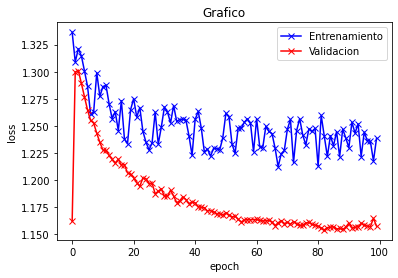

In [17]:
def plot_grap(history):
    #accuracies = [x['val_acc'] for x in history]
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    #plt.plot(accuracies, '-x')
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Entrenamiento','Validacion'])
    plt.title('Grafico');

plot_grap(history)

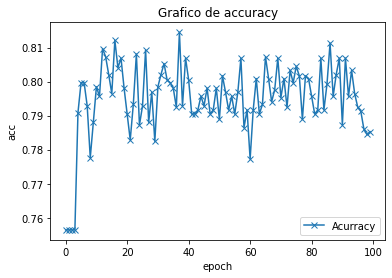

In [18]:
def plot_grap(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('acc')
    plt.legend(['Acurracy'])
    plt.title('Grafico de accuracy');

plot_grap(history)

In [19]:
@torch.no_grad()
def get_all_preds(model, loader):
    all_preds = torch.tensor([])
    for batch in loader:
        images, labels = batch

        preds = model(images)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
    return all_preds

get_all_preds(model,val_dl)

tensor([[0.9740, 0.5000, 0.5000, 0.5000],
        [0.9619, 0.5000, 0.5000, 0.5000],
        [0.9256, 0.5000, 0.5000, 0.5000],
        [0.7892, 0.6160, 0.5000, 0.5000],
        [0.9529, 0.5000, 0.5000, 0.5000],
        [0.8176, 0.6295, 0.5000, 0.5000],
        [0.9573, 0.5000, 0.5000, 0.5000],
        [0.9433, 0.5000, 0.5000, 0.5000],
        [0.9672, 0.5000, 0.5000, 0.5000],
        [0.8612, 0.6043, 0.5000, 0.5000],
        [0.9520, 0.5000, 0.5000, 0.5000],
        [0.9238, 0.5000, 0.5000, 0.5000],
        [0.9710, 0.5000, 0.5000, 0.5000],
        [0.9726, 0.5000, 0.5000, 0.5000],
        [0.9342, 0.5000, 0.5000, 0.5000],
        [0.9439, 0.5000, 0.5000, 0.5000],
        [0.9749, 0.5000, 0.5000, 0.5000],
        [0.9375, 0.5000, 0.5000, 0.5000],
        [0.9417, 0.5000, 0.5000, 0.5000],
        [0.9688, 0.5000, 0.5000, 0.5000],
        [0.9408, 0.5000, 0.5000, 0.5000],
        [0.9400, 0.5000, 0.5000, 0.5000],
        [0.9651, 0.5000, 0.5000, 0.5000],
        [0.9781, 0.5000, 0.5000, 0

In [20]:
with torch.no_grad():
    prediction_loader = torch.utils.data.DataLoader(train_dl, batch_size=32)
    train_preds = get_all_preds(model, val_dl)

In [21]:
def get_num_correct(preds, labels):
    labels=torch.from_numpy(np.array(labels))
    return preds.argmax(dim=1).eq(labels).sum().item()

preds_correct = get_num_correct(train_preds, test_dataset.targets)
print('total correct:', preds_correct)
print('accuracy:', preds_correct / len(test_dataset))

total correct: 145
accuracy: 0.8055555555555556


In [22]:
temp=torch.from_numpy(np.array(test_dataset.targets))
stacked = torch.stack((temp,train_preds.argmax(dim=1)),dim=1)

In [23]:
cmt = torch.zeros(4,4, dtype=torch.int64)
cmt

tensor([[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]])

In [24]:
for p in stacked:
    tl, pl = p.tolist()
    print(tl,pl)
    cmt[tl, pl] = cmt[tl, pl] + 1

cmt

0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 1
0 0
0 0
0 0
0 0
0 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 1
0 0
0 0
0 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 1
1 0
1 0
1 0
1 0
1 1
1 0
1 0
1 1
1 0
1 0
1 1
1 0
1 1
1 0
1 1
1 1
1 0
1 0
1 1
1 0
1 0
1 1
1 0
1 1
1 0
1 0
1 1
1 0
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
3 1


tensor([[134,   8,   0,   0],
        [ 18,  11,   0,   0],
        [  0,   8,   0,   0],
        [  0,   1,   0,   0]])

In [25]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_dataset.targets, train_preds.argmax(dim=1))
print(type(cm))
cm

<class 'numpy.ndarray'>


array([[134,   8,   0,   0],
       [ 18,  11,   0,   0],
       [  0,   8,   0,   0],
       [  0,   1,   0,   0]])

In [26]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[134   8   0   0]
 [ 18  11   0   0]
 [  0   8   0   0]
 [  0   1   0   0]]


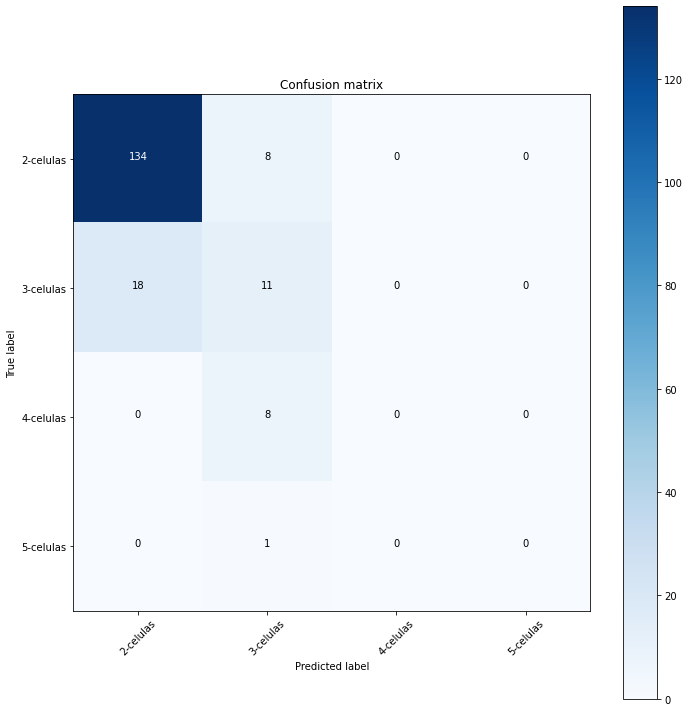

In [27]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, test_dataset.classes)

In [28]:
num_epochs = 100
learning_rate = 0.00001
model = CNNIn(4)
opt_func = torch.optim.Adagrad(model.parameters(), lr = learning_rate,lr_decay=0,weight_decay=0,
                               initial_accumulator_value=0,eps=1e-10)

history = fit(num_epochs, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.3704, val_loss: 1.4489, val_acc: 0.0064
Epoch [1], train_loss: 1.3652, val_loss: 1.3750, val_acc: 0.4395
Epoch [2], train_loss: 1.3811, val_loss: 1.3653, val_acc: 0.6094
Epoch [3], train_loss: 1.3611, val_loss: 1.3607, val_acc: 0.6967
Epoch [4], train_loss: 1.3569, val_loss: 1.3610, val_acc: 0.7147
Epoch [5], train_loss: 1.3681, val_loss: 1.3583, val_acc: 0.7183
Epoch [6], train_loss: 1.3486, val_loss: 1.3584, val_acc: 0.6963
Epoch [7], train_loss: 1.3621, val_loss: 1.3538, val_acc: 0.7095
Epoch [8], train_loss: 1.3618, val_loss: 1.3527, val_acc: 0.7212
Epoch [9], train_loss: 1.3436, val_loss: 1.3540, val_acc: 0.7155
Epoch [10], train_loss: 1.3531, val_loss: 1.3496, val_acc: 0.7416
Epoch [11], train_loss: 1.3616, val_loss: 1.3489, val_acc: 0.7328
Epoch [12], train_loss: 1.3581, val_loss: 1.3448, val_acc: 0.7716
Epoch [13], train_loss: 1.3434, val_loss: 1.3462, val_acc: 0.7792
Epoch [14], train_loss: 1.3549, val_loss: 1.3426, val_acc: 0.7572
Epoch [15], train_lo

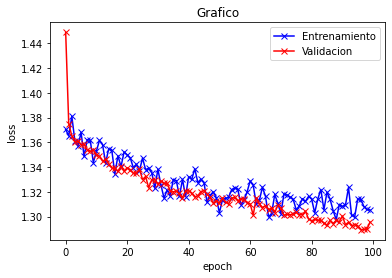

In [29]:
def plot_grap(history):
    #accuracies = [x['val_acc'] for x in history]
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    #plt.plot(accuracies, '-x')
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Entrenamiento','Validacion'])
    plt.title('Grafico');

plot_grap(history)

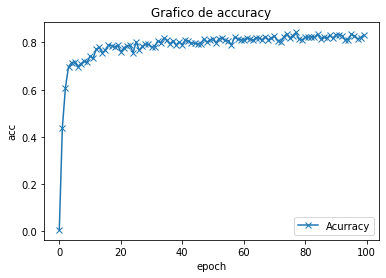

In [30]:
def plot_grap(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('acc')
    plt.legend(['Acurracy'])
    plt.title('Grafico de accuracy');

plot_grap(history)

In [31]:
@torch.no_grad()
def get_all_preds(model, loader):
    all_preds = torch.tensor([])
    for batch in loader:
        images, labels = batch

        preds = model(images)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
    return all_preds

get_all_preds(model,val_dl)

tensor([[0.7149, 0.5000, 0.5000, 0.5000],
        [0.6835, 0.5000, 0.5000, 0.5000],
        [0.6314, 0.5000, 0.5000, 0.5000],
        [0.6417, 0.5000, 0.5000, 0.5000],
        [0.6450, 0.5000, 0.5000, 0.5000],
        [0.5268, 0.5028, 0.5000, 0.5000],
        [0.6760, 0.5000, 0.5000, 0.5000],
        [0.6678, 0.5000, 0.5000, 0.5000],
        [0.6294, 0.5000, 0.5000, 0.5000],
        [0.6038, 0.5439, 0.5000, 0.5000],
        [0.6904, 0.5000, 0.5000, 0.5000],
        [0.6209, 0.5000, 0.5000, 0.5000],
        [0.6785, 0.5000, 0.5000, 0.5000],
        [0.7045, 0.5000, 0.5000, 0.5000],
        [0.6580, 0.5000, 0.5000, 0.5000],
        [0.6814, 0.5000, 0.5000, 0.5000],
        [0.7280, 0.5000, 0.5000, 0.5000],
        [0.5929, 0.5000, 0.5000, 0.5000],
        [0.6723, 0.5000, 0.5000, 0.5000],
        [0.6424, 0.5000, 0.5000, 0.5000],
        [0.6531, 0.5000, 0.5000, 0.5000],
        [0.6720, 0.5000, 0.5000, 0.5000],
        [0.6901, 0.5000, 0.5000, 0.5000],
        [0.6864, 0.5000, 0.5000, 0

In [32]:
with torch.no_grad():
    prediction_loader = torch.utils.data.DataLoader(train_dl, batch_size=32)
    train_preds = get_all_preds(model, val_dl)

In [33]:
def get_num_correct(preds, labels):
    labels=torch.from_numpy(np.array(labels))
    return preds.argmax(dim=1).eq(labels).sum().item()

preds_correct = get_num_correct(train_preds, test_dataset.targets)
print('total correct:', preds_correct)
print('accuracy:', preds_correct / len(test_dataset))

total correct: 153
accuracy: 0.85


In [34]:
temp=torch.from_numpy(np.array(test_dataset.targets))
stacked = torch.stack((temp,train_preds.argmax(dim=1)),dim=1)

In [35]:
cmt = torch.zeros(4,4, dtype=torch.int64)
cmt

tensor([[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]])

In [36]:
for p in stacked:
    tl, pl = p.tolist()
    print(tl,pl)
    cmt[tl, pl] = cmt[tl, pl] + 1

cmt

0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 1
0 0
0 0
0 0
0 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
1 1
1 0
1 0
1 0
1 1
1 1
1 0
1 1
1 0
1 0
1 1
1 1
1 1
1 0
1 1
1 1
1 1
1 1
1 1
1 0
1 0
1 1
1 0
1 1
1 0
1 0
1 1
1 0
2 1
2 1
2 1
2 1
2 3
2 1
2 1
2 1
3 1


tensor([[138,   4,   0,   0],
        [ 14,  15,   0,   0],
        [  0,   7,   0,   1],
        [  0,   1,   0,   0]])

In [37]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_dataset.targets, train_preds.argmax(dim=1))
print(type(cm))
cm

<class 'numpy.ndarray'>


array([[138,   4,   0,   0],
       [ 14,  15,   0,   0],
       [  0,   7,   0,   1],
       [  0,   1,   0,   0]])

In [38]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[138   4   0   0]
 [ 14  15   0   0]
 [  0   7   0   1]
 [  0   1   0   0]]


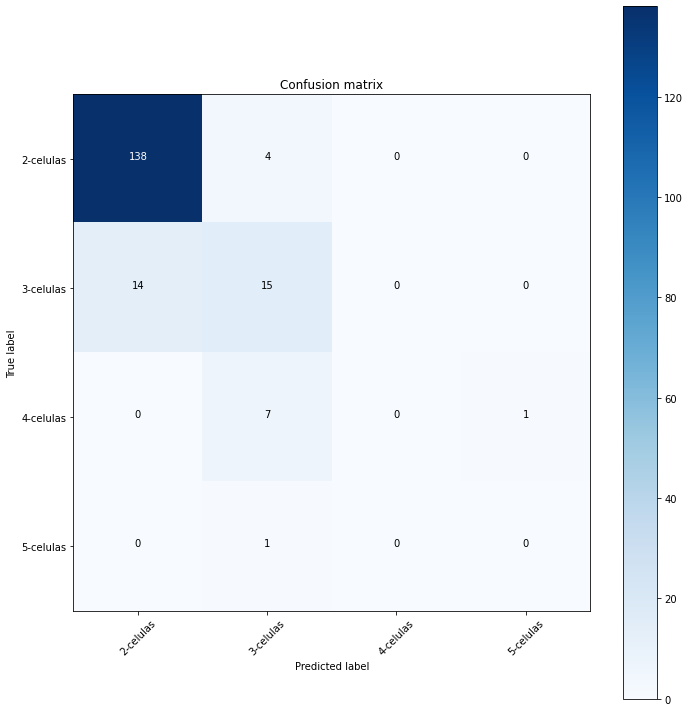

In [39]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, test_dataset.classes)

In [40]:
num_epochs = 100
learning_rate = 0.00001
train_CNN = True
model = CNNIn(4)
opt_func = torch.optim.Adadelta(model.parameters(), lr = learning_rate,rho=0.9,eps=1e-06,weight_decay=0)

history = fit(num_epochs, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.3518, val_loss: 1.2602, val_acc: 0.7512
Epoch [1], train_loss: 1.3463, val_loss: 1.3174, val_acc: 0.7460
Epoch [2], train_loss: 1.3408, val_loss: 1.3301, val_acc: 0.7564
Epoch [3], train_loss: 1.3566, val_loss: 1.3366, val_acc: 0.7512
Epoch [4], train_loss: 1.3586, val_loss: 1.3401, val_acc: 0.7408
Epoch [5], train_loss: 1.3559, val_loss: 1.3415, val_acc: 0.7564
Epoch [6], train_loss: 1.3401, val_loss: 1.3440, val_acc: 0.7512
Epoch [7], train_loss: 1.3316, val_loss: 1.3438, val_acc: 0.7512
Epoch [8], train_loss: 1.3514, val_loss: 1.3434, val_acc: 0.7460
Epoch [9], train_loss: 1.3424, val_loss: 1.3421, val_acc: 0.7512
Epoch [10], train_loss: 1.3557, val_loss: 1.3440, val_acc: 0.7460
Epoch [11], train_loss: 1.3537, val_loss: 1.3428, val_acc: 0.7512
Epoch [12], train_loss: 1.3359, val_loss: 1.3439, val_acc: 0.7356
Epoch [13], train_loss: 1.3543, val_loss: 1.3413, val_acc: 0.7512
Epoch [14], train_loss: 1.3532, val_loss: 1.3420, val_acc: 0.7408
Epoch [15], train_lo

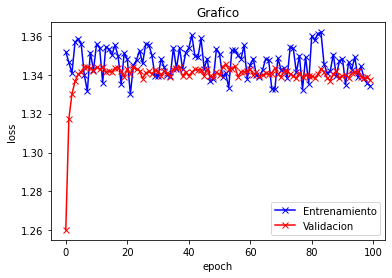

In [41]:
def plot_grap(history):
    #accuracies = [x['val_acc'] for x in history]
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    #plt.plot(accuracies, '-x')
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Entrenamiento','Validacion'])
    plt.title('Grafico');

plot_grap(history)

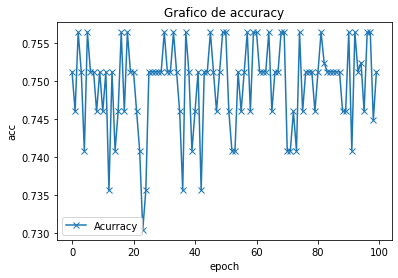

In [42]:
def plot_grap(history):
    accuracies = [x['val_acc'] for x in history]
    #train_losses = [x.get('train_loss') for x in history]
    #val_acc = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    #plt.plot(train_losses, '-bx')
    #plt.plot(val_acc, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('acc')
    plt.legend(['Acurracy'])
    plt.title('Grafico de accuracy');

plot_grap(history)

In [43]:
@torch.no_grad()
def get_all_preds(model, loader):
    all_preds = torch.tensor([])
    for batch in loader:
        images, labels = batch

        preds = model(images)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
    return all_preds

get_all_preds(model,val_dl)

tensor([[0.5938, 0.5623, 0.5000, 0.5691],
        [0.6174, 0.5005, 0.5000, 0.5166],
        [0.6464, 0.5242, 0.5000, 0.5346],
        [0.6613, 0.5536, 0.5000, 0.5436],
        [0.6276, 0.5118, 0.5000, 0.5323],
        [0.6174, 0.5000, 0.5000, 0.5167],
        [0.5971, 0.5414, 0.5000, 0.5221],
        [0.6189, 0.5069, 0.5000, 0.5424],
        [0.5909, 0.5212, 0.5000, 0.5183],
        [0.6789, 0.5129, 0.5000, 0.6077],
        [0.6256, 0.5078, 0.5000, 0.5307],
        [0.6346, 0.5290, 0.5000, 0.5000],
        [0.6317, 0.5322, 0.5120, 0.5506],
        [0.6254, 0.5057, 0.5000, 0.5053],
        [0.6243, 0.5626, 0.5000, 0.5216],
        [0.5961, 0.5253, 0.5000, 0.5378],
        [0.6096, 0.5436, 0.5000, 0.5568],
        [0.6050, 0.5582, 0.5000, 0.5463],
        [0.6286, 0.5484, 0.5000, 0.5541],
        [0.6112, 0.5167, 0.5000, 0.5517],
        [0.6401, 0.5000, 0.5000, 0.5000],
        [0.5623, 0.5000, 0.5000, 0.5777],
        [0.6460, 0.5250, 0.5000, 0.5425],
        [0.5732, 0.5719, 0.5000, 0

In [44]:
with torch.no_grad():
    prediction_loader = torch.utils.data.DataLoader(train_dl, batch_size=32)
    train_preds = get_all_preds(model, val_dl)

In [45]:
def get_num_correct(preds, labels):
    labels=torch.from_numpy(np.array(labels))
    return preds.argmax(dim=1).eq(labels).sum().item()

preds_correct = get_num_correct(train_preds, test_dataset.targets)
print('total correct:', preds_correct)
print('accuracy:', preds_correct / len(test_dataset))

total correct: 141
accuracy: 0.7833333333333333


In [46]:
temp=torch.from_numpy(np.array(test_dataset.targets))
stacked = torch.stack((temp,train_preds.argmax(dim=1)),dim=1)

In [47]:
cmt = torch.zeros(4,4, dtype=torch.int64)
cmt

tensor([[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]])

In [48]:
for p in stacked:
    tl, pl = p.tolist()
    print(tl,pl)
    cmt[tl, pl] = cmt[tl, pl] + 1

cmt

0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 3
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
3 0


tensor([[141,   0,   0,   1],
        [ 29,   0,   0,   0],
        [  8,   0,   0,   0],
        [  1,   0,   0,   0]])

In [49]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_dataset.targets, train_preds.argmax(dim=1))
print(type(cm))
cm

<class 'numpy.ndarray'>


array([[141,   0,   0,   1],
       [ 29,   0,   0,   0],
       [  8,   0,   0,   0],
       [  1,   0,   0,   0]])

In [50]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[141   0   0   1]
 [ 29   0   0   0]
 [  8   0   0   0]
 [  1   0   0   0]]


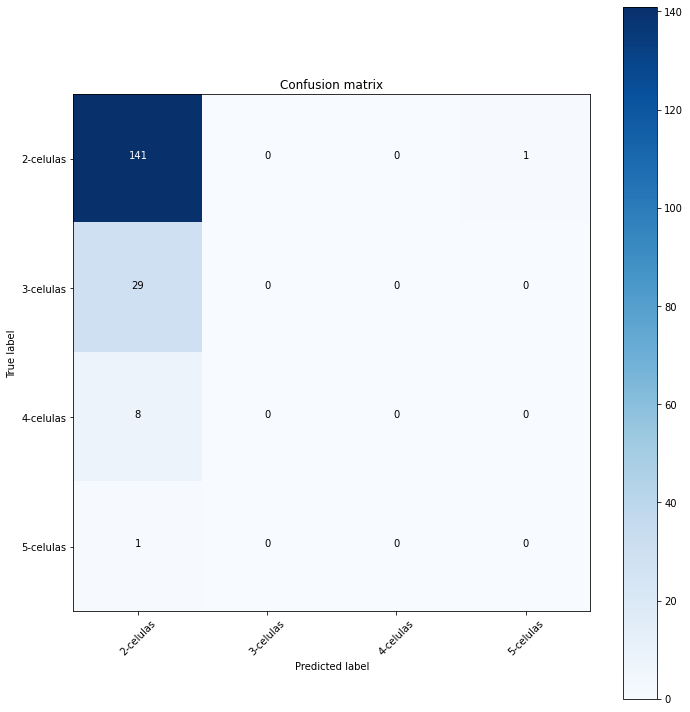

In [51]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, test_dataset.classes)